# PyTorch Custom Dataset Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the way is to do so via: Custom datasets.


## Domain Libraries

Dependin on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the pytorch domain libraries for existing data loading functions and libraries.

__Torchvision:__
https://pytorch.org/vision/stable/index.html



__Resources:__
 - Book version of course materials: https://www.learnpytorch.io/04_pytorch_custom_datasets/

 - Ground truth version of the course materials: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb


# 0. Importing PyTorch and setting up device agnostic code

In [ ]:
import torch
from torch import nn

torch.__version__

'2.0.1+cu118'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
!nvidia-smi

Thu Jul  6 11:40:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Get Data


First thing's first we need some data.

And like any good cooking show, some data has already been prepared for us.

We're going to start small.

Because we're not looking to train the biggest model or use the biggest dataset yet.

Machine learning is an iterative process, start small, get something working and increase when necessary.

The data we're going to be using is a subset of the [Food Dataset 101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

`Food101` is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Can you think of 101 different foods?

Can you think of a computer program to classify 101 foods?

I can.

A machine learning model!

Specifically, a PyTorch computer vision model like we covered in notebook 03.

Instead of 101 food classes though, we're going to start with 3: `pizza, steak and sushi`.

And instead of 1,000 images per class, we're going to start with a random 10% (start small, increase when necessary).

If you'd like to see where the data came from you see the following resources:

 - Original Food101 dataset and paper website.
`torchvision.datasets.Food101` - the version of the data I downloaded for this notebook.
 -[`extras/04_custom_data_creation`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).ipynb - a notebook I used to format the Food101 dataset to use for this notebook.
 - `data/pizza_steak_sushi.zip` - the zip archive of pizza, steak and sushi images from Food101, created with the notebook linked above.
Let's write some code to download the formatted data from GitHub.

Note: The dataset we're about to use has been pre-formatted for what we'd like to use it for. However, you'll often have to format your own datasets for whatever problem you're working on. This is a regular practice in the machine learning world.

In [ ]:
from torch.cuda.graphs import is_current_stream_capturing
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists.. skipping download")

else: print(f"{image_path} does not exist, creating one...")
image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and shushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak and sushi data...")
  f.write(request.content)

# Unzip pizza, steak and sushi
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak and sushi data...


All the dataset is in format of data storage structure,

pizza_steak_sushi/ <- overall dataset folder

    train/ <- training images
        pizza/ <- class name as folder name
            image01.jpeg
            image02.jpeg
            ...
        steak/
            image24.jpeg
            image25.jpeg
            ...
        sushi/
            image37.jpeg
            ...
    test/ <- testing images
        pizza/
            image101.jpeg
            image102.jpeg
            ...
        steak/
            image154.jpeg
            image155.jpeg
            ...
        sushi/
            image167.jpeg
            ...


# 2. Becoming one with the data
(Data preparation and Data Exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walk through dir_path returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:

 1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.

 2. Pick a random image path using Python's `random.choice().`

 3. Get the image class name using `pathlib.Path.parent.stem.`

 4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (PIL stands for Python Image Library).
We'll then show the image and print some metadata.

data/pizza_steak_sushi/train/pizza/3530210.jpg
pizza
Random image path: data/pizza_steak_sushi/train/pizza/3530210.jpg
Image class: pizza
Image height: 512
Image widht: 512


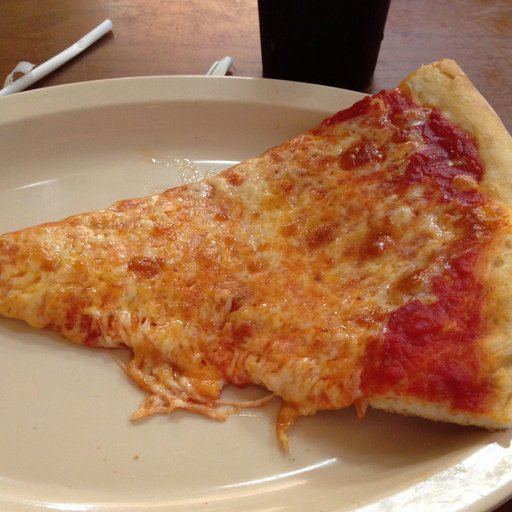

In [ ]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # grab together everything from directories


# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get the image class from path name (the image class is the same name of directory where image is located)
image_class = random_image_path.parent.stem
print(image_class)

# 4. Open up the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image widht: {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

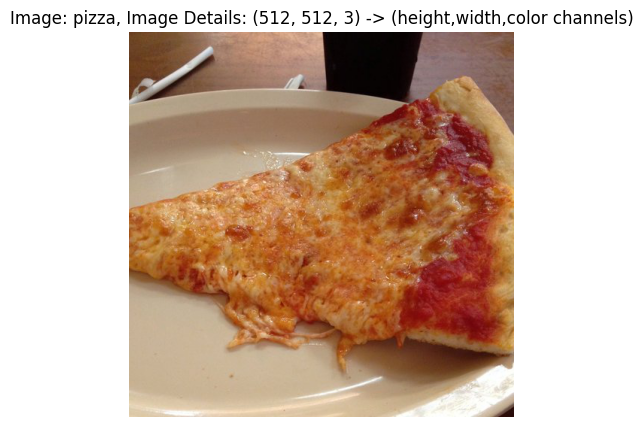

In [ ]:
# Exercise: Try and visualize image using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Convert image data into numpy array
img_as_array = np.asarray(img)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(img_as_array)
plt.title(f"Image: {image_class}, Image Details: {img_as_array.shape} -> (height,width,color channels)")
plt.axis(False)

# 3. Transforming data

Before we can use our image data with PyTorch we need to:

 1. Turn it into tensors (numerical representations of our images).

 2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and DataLoader for short.

Problem space:

 __Pre-built Datasets and Functions__

`Vision` |	[__torchvision.datasets__](https://pytorch.org/vision/stable/generated/torchvision.datasets.VisionDataset.html#torchvision.datasets.VisionDataset)

`Audio` | 	__torchaudio.datasets__

`Text` |	__torchtext.datasets__

`Recommendation system` |	__torchrec.datasets__


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transforms = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [ ]:
data_transforms(img).shape

torch.Size([3, 64, 64])

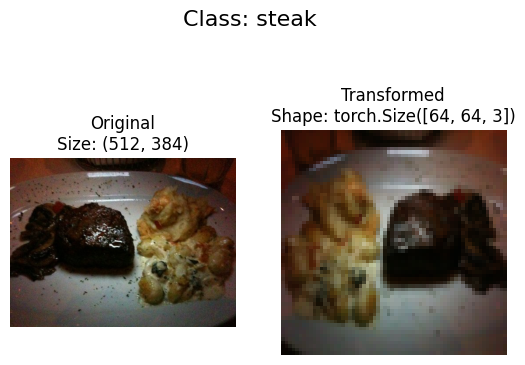

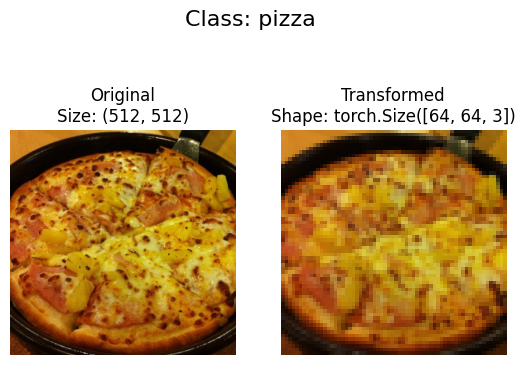

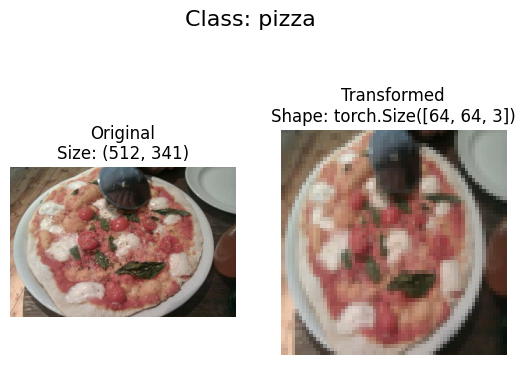

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target images
      transformed_image = transform(f).permute(1, 2, 0)
      # Note: permute() will change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list, transform=data_transforms, n=3, seed=None)




# 4. Option 1: Loading Image Data Using ImageFolder

We can load image classification data using `torchvision.datasets.ImageFolder` - https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,# a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_names_dict = train_data.class_to_idx
class_names_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the len of dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor: \n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: 
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color channels, height, width]
Image Permuted: torch.Size([64, 64, 3]) -> [height, width, color channels]


Text(0.5, 1.0, 'pizza')

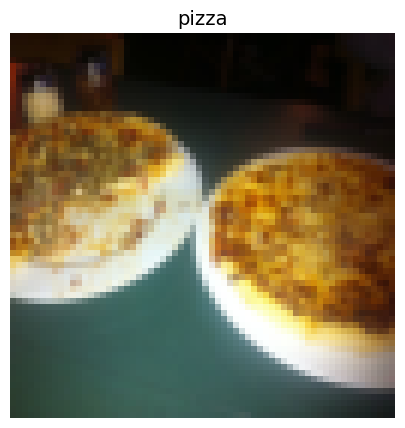

In [ ]:
# Rearrange the order dimesions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color channels, height, width]")
print(f"Image Permuted: {img_permute.shape} -> [height, width, color channels]")

plt.figure(figsize=(6, 5))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

Notice the image is now more pixelated (less quality).

This is due to it being resized from `512x512` to `64x64` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

### 4.1 Turn loaded images into DataLoader's

Turning our Dataset's into DataLoader's makes them iterable so a model can go through learn the relationships between samples and targets (features and labels).

In [ ]:
# Turn our train and test datasets into DataLoader's
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7efed02ffc10>,
 <torch.utils.data.dataloader.DataLoader at 0x7efed02ff4f0>)

In [ ]:
# Let's check the shape of train_dataloader
img, label = next(iter(train_dataloader))

print(f"Image shape; {img.shape} -> [batch_size, channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape; torch.Size([1, 3, 64, 64]) -> [batch_size, channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader's ` with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

# 5. Option 2: Loading Image Data with a Custom Dataset.

 1. Want to able to load images from file
 2. Want to be able to get class names from dataset
 3. Want to be able to get classes as dictionary from the Dataset


Pros:
 - Can create `Dataset` out of almost anything.
 - Not limited to PyTorch pre-built `Dataset` functions

Cons:
 - Even though you could create `Dataset` out of almost anything, it doesn't mean it will work.

 - Using a custom `Dataset` often results in us writing more code, whic could be prone to errors or performance issues.

All custom datasets in PyTorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset



In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper functions to get the class names

We want a function to:
 1. Get the class names using `os.sc`


# Part 21:33 to 22:43 has been skipped, need to be done later.

Resource: __Daniel Bourke Learning PyTorch Video__

# 7. Model 0: TinyVGG without data

Let's replicate TinyVGG architecture from the CNN Explainer webiste: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating Transforms and loading data for Model 0

In [ ]:
# Creati simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform= simple_transform,
                                  target_transform= None)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                 transform=simple_transform)

# 2. Turn data into dataloaders

# Setup batch size and num of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating dataloader with Batch size: {BATCH_SIZE}, and num of workers: {NUM_WORKERS}")

# Create Dataloader's
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)


train_dataloader_simple, test_dataloader_simple

Creating dataloader with Batch size: 32, and num of workers: 2


(<torch.utils.data.dataloader.DataLoader at 0x7efed0461ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x7efed063f4c0>)

### 7.2 Create TinyVGG Model class

In [ ]:
# class TinyVGGmodelV0(nn.Module):

#   """
#      Model architecture copying TinyVGG from:
#     https://poloclub.github.io/cnn-explainer/
#   """
#   def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
#     super().__init__()
#     self.Conv_block_1 = nn.Sequential(
#         nn.Conv2d(in_channels=input_shape,
#                   out_channels=16,
#                   kernel_size=3,
#                   stride=1,
#                   padding=0),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=16,
#                   out_channels=32,
#                   kernel_size=3,
#                   stride=1,
#                   padding=0),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=1,
#                      stride=1) # default stride value is same as kernel_size
#     )

#     self.Conv_block_2 = nn.Sequential(
#         nn.Conv2d(in_channels=32,
#                   out_channels=128,
#                   kernel_size=3,
#                   stride=1,
#                   padding=0),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=128,
#                   out_channels=hidden_units,
#                   kernel_size=3,
#                   stride=1,
#                   padding=0),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=1,
#                      stride=1)
#     )

#     self.classfier = nn.Sequential(
#         nn.Flatten(),
#         nn.Linear(in_features=hidden_units * 60 * 60,
#                   out_features=output_shape)
#     )

#   def forward(self, x):
#     x = self.Conv_block_1(x)
#     #print(x.shape)
#     #x = self.Conv_block_2(x)
#     #print(x.shape)
#     x = self.classfier(x)
#     #print(x.shape)
#     return x
#     # return self.classfier(self.Conv_block_2(self.Conv_block_1(x))) # Benefits in operator fusion
#     # More on operator fusion https://horace.io/brrr_intro.html

import torch
import torch.nn as nn

class PyTorchModel(nn.Module):
    def __init__(self, num_classes):
        super(PyTorchModel, self).__init__()

        self.data_augmentation = nn.Sequential(
            # Implement your data augmentation layers here
        )

        self.normalization = nn.Sequential(
            # Implement your normalization layers here
        )

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 4 * 4 * 4, 128)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.data_augmentation(x)
        x = self.normalization(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.dropout(x)
        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)

        return x

# Create an instance of the PyTorch model
num_classes = 10  # Replace with the actual number of classes
pytorch_model = PyTorchModel(num_classes).to(device)



In [ ]:
pytorch_model

PyTorchModel(
  (data_augmentation): Sequential()
  (normalization): Sequential()
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### 7.3 Try a forward pass on a single image (to test the model)

In [ ]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# Try the forward pass
pytorch_model(image_batch.to(device))

tensor([[-0.0273,  0.0514,  0.0325,  0.0834, -0.0574, -0.0570, -0.0785, -0.0587,
          0.0300,  0.0113],
        [-0.0214,  0.0476,  0.0441,  0.0921, -0.0643, -0.0586, -0.0700, -0.0526,
          0.0412,  0.0145],
        [-0.0187,  0.0456,  0.0314,  0.0824, -0.0682, -0.0664, -0.0824, -0.0496,
          0.0239,  0.0098],
        [-0.0261,  0.0447,  0.0426,  0.0727, -0.0502, -0.0669, -0.0772, -0.0633,
          0.0359,  0.0158],
        [-0.0263,  0.0604,  0.0471,  0.0905, -0.0733, -0.0685, -0.0761, -0.0631,
          0.0293,  0.0166],
        [-0.0205,  0.0422,  0.0392,  0.0900, -0.0494, -0.0622, -0.0843, -0.0560,
          0.0291,  0.0172],
        [-0.0187,  0.0557,  0.0235,  0.0877, -0.0506, -0.0775, -0.0621, -0.0586,
          0.0451,  0.0141],
        [-0.0217,  0.0622,  0.0272,  0.0917, -0.0723, -0.0585, -0.0473, -0.0624,
          0.0465, -0.0006],
        [-0.0303,  0.0540,  0.0346,  0.0790, -0.0671, -0.0634, -0.0725, -0.0651,
          0.0307,  0.0261],
        [-0.0250,  

### 7.4 Use `torchinfo` to get an idea of the shapes on layers


In [ ]:
try:
  import torchinfo

except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])


NameError: ignored

### 7.5 Create train & test loop functions

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:

 - `train_step()` - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader.
 - `test_step()` - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader.

 - `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):

  # Put model to train
  model.train()

  # Setup train loss and train acc values
  train_acc, train_loss = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send the data to target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model(X)

    # 2. Calculate  and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumulate accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy
  test_loss, test_acc = 0, 0

  # Turn on the inference mode
  with torch.inference_mode():
    # Loop through dataloader batches
    for batch, (X,y) in enumerate(dataloader):
      # Send the X and y to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate and accumulate test loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate test accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 7.6 Create a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes various model paramaters + optimizer + dataloader
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

# 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

# 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer_fn,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

# 4. Print out what's happenning..
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


# 5. Update our results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

# 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and Evaluate Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_OF_EPOCHS = 5

# Setup the loss and optimizer function
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(params=pytorch_model.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train the model_0
model_0_results = train(model=pytorch_model,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer_fn,
                        loss_fn=loss_fn,
                        epochs=NUM_OF_EPOCHS,
                        device=device)

end_time = timer()
print(f"Total training time: {end_time - start_time:.4f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.4487 | Train_acc: 0.3789 | Test loss: 3.3715 | Test Acc: 0.2604
Epoch: 1 | Train loss: 1.6123 | Train_acc: 0.4258 | Test loss: 1.5165 | Test Acc: 0.2604
Epoch: 2 | Train loss: 1.2219 | Train_acc: 0.2969 | Test loss: 1.0391 | Test Acc: 0.5417
Epoch: 3 | Train loss: 1.1107 | Train_acc: 0.3086 | Test loss: 1.2191 | Test Acc: 0.2604
Epoch: 4 | Train loss: 1.1316 | Train_acc: 0.3047 | Test loss: 1.1662 | Test Acc: 0.1979
Total training time: 16.5561 seconds


### 7.8 Plot the loss curve of Model 0

In [ ]:
# Get the model_0 keys
model_0_results.keys()

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_0_results)

# 8. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentaion

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_augment_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Create train and test datasets and dataloader with augementation

In [ ]:
train_augmented_dataset = datasets.ImageFolder(root=train_dir,
                                               transform=train_transform_trivial)

test_augmented_dataset = datasets.ImageFolder(root=test_dir,
                                              transform=test_augment_simple)


train_augmented_dataset, test_augmented_dataset


In [ ]:
# Creating the dataloader for the above datasets
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_augmented_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_augmented_dataset,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

### 9.3 Construct and train model 1

In [ ]:
# Create model_1 and send to target device
torch.manual_seed(0)
model_1 = TinyVGGmodelV0(input_shape=3,
                         hidden_units=32,
                         output_shape=len(class_names)).to(device)

model_1

In [ ]:
try:
  import torchinfo

except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_1, input_size=[1, 3, 64, 64])


### 9.4 Train the model_1 using our `train` function

In [ ]:
# Set manual and cuda seed
#torch.cuda.manual_seed(42)

# Set number of epochs
EPOCHS = 30

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

# Start the timer
start_time_augmented = timer()

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_augmented,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

end_time_augmented = timer()
print(f"Total training time: {end_time_augmented - start_time_augmented:.4f} seconds")

In [ ]:
plot_loss_curves(model_1_results)